# `Практикум по программированию на языке Python`

## `Задание 1.5. Классификация изображений`.

#### Фамилия, имя: Богачев Владимир

Дата выдачи: <span style="color:red">__5 марта__</span>.

Мягкий дедлайн: <span style="color:red">__12 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __3 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2024`

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt

random_seed = 0
torch.manual_seed(random_seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## `Задание 1. Загрузка данных (0.5 балла)`

В этой домашке работа с данными будем максимально облегчённой. Мы скачаем MNIST с помощью [стандартных средств](https://pytorch.org/vision/0.8/datasets.html#mnist) торча. Посмотреть список других доступных датасетов можно [здесь](https://pytorch.org/vision/0.8/datasets.html).

In [2]:
def load_mnist(train, transform=None):    
    if transform is None:
        transform = T.ToTensor()
    return torchvision.datasets.MNIST(
        root='./data',
        train=train,
        transform=transform,
        download=True
    )

Пиксели изображений принимают значения [0,1]. Скачайте датасет и посчитайте выборочное среднее и выборочное стандартное отклонение для значения пикселя. Т.е. должно получиться число `mean` для среднего, и число `std` для стандартного отклонения.

*Подсказка.* Подумайте, на какой части датасета нужно считать эти статистики (обучение или валидация), чтобы предотвратить утечку данных.

*Подсказка.* У торч датасета реализован метод `__getitem__`, т.е. его можно индексировать `dataset[i]`.

In [3]:
norm_transform = T.Compose([
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float32)
])

data_train = load_mnist(True, transform=norm_transform)

X_train = torch.stack([data_train[i][0] for i in range(len(data_train))])

print(X_train.dtype, X_train.shape)

mean =  torch.mean(X_train)
std =  torch.std(X_train)
print(f"mean = {mean:.2f}, std = {std:.2f}")

torch.float32 torch.Size([60000, 1, 28, 28])
mean = 0.13, std = 0.31


Полученные значения можно применить для нормализации изображений, когда будем подавать их в нейросеть.

In [4]:
norm_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std)
])

train_mnist = load_mnist(True, norm_transform)
val_mnist = load_mnist(False, norm_transform)

Во время обучения данные подаются в нейросеть батчами.

Обычно batch_size выбирается так, чтобы во время обучения получалась меньше дисперсия градиента (ну вы уже знакомы с sgd), также часто batch_size выбирается максимально возможным по ресурсам.

Для этой задачи нам хватит batch_size = 64 во время обучения.

*Ответьте на вопрос:* Почему в большинстве задач для валидации и тестирования можно выбирать batch_size больше? 

In [5]:
from torch.utils.data import DataLoader

batch_size_train = 64
batch_size_test = 1000

train_mnist_loader = DataLoader(
    dataset=train_mnist,
    batch_size=batch_size_train,
    shuffle=True,
    drop_last=True,
    num_workers=6
)

val_mnist_loader = torch.utils.data.DataLoader(
    dataset=val_mnist,
    batch_size=batch_size_test,
    shuffle=False,
    drop_last=False,
    num_workers=3
)

In [6]:
images, labels = next(iter(train_mnist_loader))
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

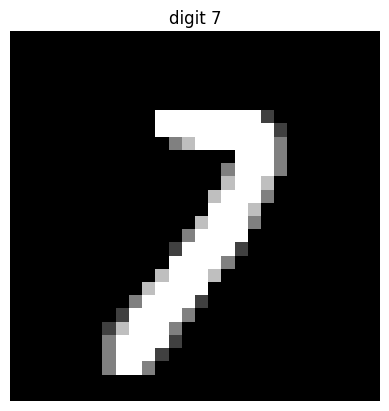

In [7]:
i = 3
plt.title(f'digit {labels[i]}')
plt.imshow(images[i, 0], cmap='gray')
plt.axis('off')
plt.show()

## `Задание 2. Цикл обучения (1.5 балла)`

Ниже предоставлен базовый вариант цикла обучения, представленный тремя функциями: `train_epoch`, `val_epoch`, `train_val`.

In [8]:
def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""
    
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)   # send data to device
        optimizer.zero_grad()   # zero out grads, collected from previous batch
        logits = network(images)  # forward pass
        loss = criterion(logits, labels, reduction='mean')
        loss.backward()
        optimizer.step()

In [9]:
@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0

    network.eval()  # switch network submodules to test mode
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        logits = network(images)
        val_loss += criterion(logits, labels, reduction='sum').item()
        pred = torch.argmax(logits, dim=1)
        correct += torch.sum(pred == labels).item()

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'Accuracy: {correct}/{len(val_loader.dataset)}',
        f'({100. * val_accur:.0f}%)',
    )

In [10]:
def train_val(
    network,
    n_epochs,
    criterion,
    optimizer,
    train_loader,
    val_loader,
):
    """full cycle of neural network training"""

    val_epoch(network, val_loader, criterion)
    for epoch in range(1, n_epochs + 1):
        train_epoch(network, train_loader, criterion, optimizer)
        val_epoch(network, val_loader, criterion)

Для проверки, что все работает, обучите бейзлайн -- однослойную [полносвязную](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) сеть на [кросс-энтропийный лосс](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html). 


*Заметьте*, что на вход этому лоссу нужно подавать сырой выход нейросети, а не результат применения софтмакса.

In [11]:
class LogReg(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=input_size, out_features=output_size)

    def forward(self, x):
        # print(f"{x.shape=}", end='\t')
        x = self.flatten(x)
        # print(f"{x.shape=}", end='\t')
        x = self.linear(x)
        # print(f"{x.shape=}", end='\n')

        return x

In [12]:
model = LogReg(28 * 28, 10).to(device)

train_val(
    network=model,
    criterion=nn.functional.cross_entropy,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4),
    train_loader=train_mnist_loader,
    val_loader=val_mnist_loader,
    n_epochs=20,
)

Test set: Avg. loss: 2.4114 Accuracy: 843/10000 (8%)
Test set: Avg. loss: 0.4583 Accuracy: 8855/10000 (89%)
Test set: Avg. loss: 0.3604 Accuracy: 9037/10000 (90%)
Test set: Avg. loss: 0.3255 Accuracy: 9083/10000 (91%)
Test set: Avg. loss: 0.3065 Accuracy: 9149/10000 (91%)
Test set: Avg. loss: 0.2956 Accuracy: 9182/10000 (92%)
Test set: Avg. loss: 0.2887 Accuracy: 9188/10000 (92%)
Test set: Avg. loss: 0.2847 Accuracy: 9202/10000 (92%)
Test set: Avg. loss: 0.2810 Accuracy: 9205/10000 (92%)
Test set: Avg. loss: 0.2774 Accuracy: 9209/10000 (92%)
Test set: Avg. loss: 0.2761 Accuracy: 9227/10000 (92%)
Test set: Avg. loss: 0.2738 Accuracy: 9224/10000 (92%)
Test set: Avg. loss: 0.2720 Accuracy: 9237/10000 (92%)
Test set: Avg. loss: 0.2725 Accuracy: 9238/10000 (92%)
Test set: Avg. loss: 0.2718 Accuracy: 9238/10000 (92%)
Test set: Avg. loss: 0.2706 Accuracy: 9216/10000 (92%)
Test set: Avg. loss: 0.2694 Accuracy: 9240/10000 (92%)
Test set: Avg. loss: 0.2682 Accuracy: 9257/10000 (93%)
Test set: Av

Test set: Avg. loss: 2.4114 Accuracy: 843/10000 (8%)
Test set: Avg. loss: 0.2837 Accuracy: 9179/10000 (92%)
Test set: Avg. loss: 0.2796 Accuracy: 9201/10000 (92%)
Test set: Avg. loss: 0.2812 Accuracy: 9199/10000 (92%)

## `Задание 3. Логирование (3 балл)`

Скопируйте и перепишите функции `train_epoch`, `val_epoch`, `train_val` таким образом, чтобы
- во время обучения раз в `logging_interval` шагов оптимизации выводились лосс и аккураси на одном батче (пример ниже, но не обязательно делать идентично)
- происходило сохранение весов лучшей (по аккураси на валидации) модели и состояния оптимизатора ([в помощь](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended))
- в конце обучения выводился и сохранялся график-саммари (пример ниже, но не обязательно делать идентично)

*Ответьте на вопрос:* Что хранится в состоянии оптимизатора? Зачем нужно его сохранять? Приведите хотя бы один пример оптимизатора, для которого есть смысл сохранять состояние.

In [13]:
class Logger:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        
        self.best_val_acc = -1
        self.best_model_wts = None
        self.best_optimizer_st = None
    
    def log_training(self, epoch, train_loss, train_acc):
        self.train_loss.append(train_loss)
        self.train_acc.append(train_acc)
    
    def log_validation(self, epoch, val_loss, val_acc, model, optimizer):
        self.val_loss.append(val_loss)
        self.val_acc.append(val_acc)
        
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            # TODO: save model and optimizer

In [14]:
def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
    logger: Logger,
    logging_interval: int = 1,
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""
    
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    logger_step = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)   # send data to device
        optimizer.zero_grad()   # zero out grads, collected from previous batch
        logits = network(images)  # forward pass
        loss = criterion(logits, labels, reduction='mean')
        loss.backward()
        optimizer.step()
        logger_step = (logger_step + 1) % logging_interval
        
        if logger_step == 0:
            pred = logits.argmax(dim=1)
            train_accuracy = torch.sum(pred == labels).item() / len(labels)
            logger.log_training(-1, loss.item(), train_accuracy)

In [15]:
@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
    logger: Logger
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0

    network.eval()  # switch network submodules to test mode
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        logits = network(images)
        val_loss += criterion(logits, labels, reduction='sum').item()
        pred = torch.argmax(logits, dim=1)
        correct += torch.sum(pred == labels).item()

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    logger.log_validation(-1, val_loss, val_accur, None, None)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'Accuracy: {correct}/{len(val_loader.dataset)}',
        f'({100. * val_accur:.0f}%)',
    )

In [16]:
def train_val(
    network,
    n_epochs,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    logger: Logger,
    logging_interval: int = 5,
):
    """full cycle of neural network training"""

    val_epoch(network, val_loader, criterion, logger)
    for epoch in range(1, n_epochs + 1):
        train_epoch(network, train_loader, criterion, optimizer, logger, logging_interval)
        val_epoch(network, val_loader, criterion, logger)

In [17]:
model = LogReg(28 * 28, 10).to(device)

lg = Logger()

train_val(
    network=model,
    criterion=nn.functional.cross_entropy,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4),
    train_loader=train_mnist_loader,
    val_loader=val_mnist_loader,
    n_epochs=20,
    logger=lg,
    logging_interval=5
)

Test set: Avg. loss: 2.4668 Accuracy: 927/10000 (9%)
Test set: Avg. loss: 0.4624 Accuracy: 8866/10000 (89%)
Test set: Avg. loss: 0.3609 Accuracy: 9058/10000 (91%)
Test set: Avg. loss: 0.3254 Accuracy: 9125/10000 (91%)
Test set: Avg. loss: 0.3066 Accuracy: 9152/10000 (92%)
Test set: Avg. loss: 0.2954 Accuracy: 9176/10000 (92%)
Test set: Avg. loss: 0.2898 Accuracy: 9187/10000 (92%)
Test set: Avg. loss: 0.2850 Accuracy: 9192/10000 (92%)
Test set: Avg. loss: 0.2812 Accuracy: 9203/10000 (92%)
Test set: Avg. loss: 0.2791 Accuracy: 9208/10000 (92%)
Test set: Avg. loss: 0.2766 Accuracy: 9206/10000 (92%)
Test set: Avg. loss: 0.2749 Accuracy: 9208/10000 (92%)
Test set: Avg. loss: 0.2726 Accuracy: 9221/10000 (92%)
Test set: Avg. loss: 0.2721 Accuracy: 9219/10000 (92%)
Test set: Avg. loss: 0.2699 Accuracy: 9223/10000 (92%)
Test set: Avg. loss: 0.2700 Accuracy: 9224/10000 (92%)
Test set: Avg. loss: 0.2693 Accuracy: 9240/10000 (92%)
Test set: Avg. loss: 0.2690 Accuracy: 9238/10000 (92%)
Test set: Av

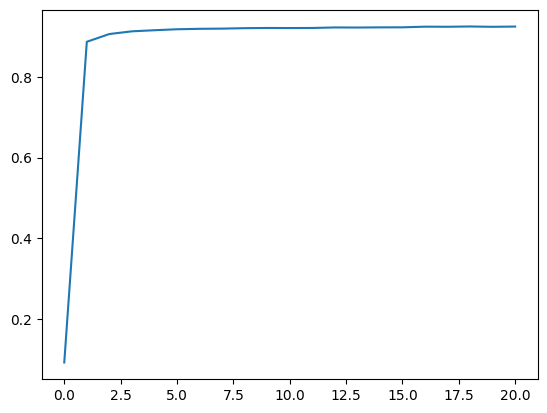

In [18]:
plt.plot(lg.val_acc)

Загрузите лучшие веса модели и подсчитайте аккураси на валидации, чтобы подтвердить что веса сохранились корректно.

In [ ]:
# your code is here

Загрузите сохранённое состояние оптимизатора и сделайте две эпохи обучения, чтобы подтвердить, что состояния оптимизатора были сохранены корректно.

In [ ]:
# your code is here

## `Задание 4. Логирование с помощью tensorboard (1 балл)`

На самом деле это дурной тон логировать обучение нейросети так, как это сделали вы выше. Дело в том, что весь функционал уже реализован в [`tensorboard`](https://pytorch.org/docs/stable/tensorboard.html), а вы написали велосипед.

In [2]:
! pip3 install tensorboard
from torch.utils.tensorboard import SummaryWriter

Если у вас есть доступ к терминалу и браузеру, то удобнее всего ввести команду
```bash
tensorboard --logdir .
```
и открыть UI в выделенном локалхосте. 

Если вы работаете в гугл колабе, то можете запустить UI как виджет в Jupyter:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir .

Как только вы начнете логировать в объект типа `SummaryWriter`, в UI начнут строиться кривые обучения.

Скопируйте и перепишите функции обучения таким образом, чтобы логирование происходило в `tensorboard`.

*Замечание.* Вам пригодится метод `add_scalar`, чтобы сохранять лосс и аккураси, и метод `add_hparams`, чтобы сохранить важные гиперпараметры (например, кодовое имя архитектуры сети) и финальное достигнутое качество.

In [3]:
from itertools import count

In [4]:
def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
    writer: SummaryWriter,
    logging_interval: int = 1,
    logger_step_cntr: count = None,
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""
    
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    logger_step_cntr = count() if logger_step_cntr is None else logger_step_cntr
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)   # send data to device
        optimizer.zero_grad()   # zero out grads, collected from previous batch
        logits = network(images)  # forward pass
        loss = criterion(logits, labels, reduction='mean')
        loss.backward()
        optimizer.step()
        logger_step = next(logger_step_cntr)
        
        if logger_step % logging_interval == 0:
            pred = logits.argmax(dim=1)
            train_accuracy = torch.sum(pred == labels).item() / len(labels)
            writer.add_scalar('Loss/train', loss.item(), logger_step // logging_interval)
            writer.add_scalar('Accuracy/train', train_accuracy, logger_step // logging_interval)

In [5]:
@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
    writer: SummaryWriter,
    epoch_no: int
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0

    network.eval()  # switch network submodules to test mode
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        logits = network(images)
        val_loss += criterion(logits, labels, reduction='sum').item()
        pred = torch.argmax(logits, dim=1)
        correct += torch.sum(pred == labels).item()

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    writer.add_scalar('Loss/val', val_loss, epoch_no)
    writer.add_scalar('Accuracy/val', val_accur, epoch_no)
    # logger.log_validation(-1, val_loss, val_accur, None, None)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'Accuracy: {correct}/{len(val_loader.dataset)}',
        f'({100. * val_accur:.0f}%)',
    )
    
    return val_loss, val_accur

In [6]:
def train_val(
    network,
    n_epochs,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    writer: SummaryWriter,
    logging_interval: int = 5,
    model_name: str = None,
):
    """full cycle of neural network training"""

    if model_name is not None:
        writer.add_hparams(run_name=model_name, hparam_dict={}, metric_dict={})

    logger_step_cntr = count(0)
    val_loss, val_accur = val_epoch(network, val_loader, criterion, writer, epoch_no=0)
    for epoch in range(1, n_epochs + 1):
        train_epoch(network, train_loader, criterion, optimizer, writer, logging_interval, logger_step_cntr)
        val_loss, val_accur = val_epoch(network, val_loader, criterion, writer, epoch_no=epoch)
    
    # if model_name is not None:
    #     writer.add_hparams(run_name=model_name, hparam_dict=network.state_dict(), metric_dict={'val_loss': val_loss, 'val_accur': val_accur})

In [31]:
model = LogReg(28 * 28, 10).to(device)

writer = SummaryWriter()

train_val(
    network=model,
    criterion=nn.functional.cross_entropy,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4),
    train_loader=train_mnist_loader,
    val_loader=val_mnist_loader,
    n_epochs=20,
    writer=writer,
    logging_interval=5,
    model_name='my_nn'
)

Test set: Avg. loss: 2.4057 Accuracy: 1434/10000 (14%)
Test set: Avg. loss: 0.4585 Accuracy: 8858/10000 (89%)
Test set: Avg. loss: 0.3596 Accuracy: 9047/10000 (90%)
Test set: Avg. loss: 0.3259 Accuracy: 9109/10000 (91%)
Test set: Avg. loss: 0.3066 Accuracy: 9140/10000 (91%)
Test set: Avg. loss: 0.2975 Accuracy: 9155/10000 (92%)
Test set: Avg. loss: 0.2900 Accuracy: 9182/10000 (92%)
Test set: Avg. loss: 0.2854 Accuracy: 9176/10000 (92%)
Test set: Avg. loss: 0.2809 Accuracy: 9193/10000 (92%)
Test set: Avg. loss: 0.2794 Accuracy: 9208/10000 (92%)
Test set: Avg. loss: 0.2774 Accuracy: 9213/10000 (92%)
Test set: Avg. loss: 0.2739 Accuracy: 9216/10000 (92%)
Test set: Avg. loss: 0.2742 Accuracy: 9209/10000 (92%)
Test set: Avg. loss: 0.2722 Accuracy: 9230/10000 (92%)
Test set: Avg. loss: 0.2710 Accuracy: 9227/10000 (92%)
Test set: Avg. loss: 0.2716 Accuracy: 9224/10000 (92%)
Test set: Avg. loss: 0.2700 Accuracy: 9235/10000 (92%)
Test set: Avg. loss: 0.2681 Accuracy: 9245/10000 (92%)
Test set: 

TypeError: hparam_dict and metric_dict should be dictionary.

In [26]:
writer.flush()

## `Задание 5. Побейте бейзлайн (2+2 балла)`

На датасете [`CIFAR-10`](https://pytorch.org/vision/0.8/datasets.html#torchvision.datasets.CIFAR10) обучите модель, которая выдает аккураси `>=0.7` (2 балла) и аккураси `>=0.8` (ещё 2 балла).
- Можете использовать любые модули `pytorch`, любые оптимизаторы и шедулеры, можете использовать аугментации ([например](https://pytorch.org/vision/stable/transforms.html))
- Для отслеживания экспериментов используйте логирование с `tensorboard`, не забывайте давать осмысленные имена эспериментам и логировать нужные гиперпараметры, сохранять веса сети и состояние оптимизатора.

In [2]:
from torch.utils.tensorboard import SummaryWriter
from itertools import count

In [3]:
def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
    writer: SummaryWriter,
    logging_interval: int = 1,
    logger_step_cntr: count = None,
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""
    
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    logger_step_cntr = count() if logger_step_cntr is None else logger_step_cntr
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)   # send data to device
        optimizer.zero_grad()   # zero out grads, collected from previous batch
        logits = network(images)  # forward pass
        loss = criterion(logits, labels, reduction='mean')
        loss.backward()
        optimizer.step()
        logger_step = next(logger_step_cntr)
        
        if logger_step % logging_interval == 0:
            pred = logits.argmax(dim=1)
            train_accuracy = torch.sum(pred == labels).item() / len(labels)
            writer.add_scalar('Loss/train', loss.item(), logger_step // logging_interval)
            writer.add_scalar('Accuracy/train', train_accuracy, logger_step // logging_interval)

In [4]:
@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
    writer: SummaryWriter,
    epoch_no: int
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0

    network.eval()  # switch network submodules to test mode
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        logits = network(images)
        val_loss += criterion(logits, labels, reduction='sum').item()
        pred = torch.argmax(logits, dim=1)
        correct += torch.sum(pred == labels).item()

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    writer.add_scalar('Loss/val', val_loss, epoch_no)
    writer.add_scalar('Accuracy/val', val_accur, epoch_no)
    # logger.log_validation(-1, val_loss, val_accur, None, None)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'Accuracy: {correct}/{len(val_loader.dataset)}',
        f'({100. * val_accur:.0f}%)',
    )
    
    return val_loss, val_accur

In [24]:
def train_val(
    network,
    n_epochs,
    criterion,
    optimizer,
    lr_scheduler,
    train_loader,
    val_loader,
    writer: SummaryWriter,
    logging_interval: int = 5,
    run_name: str = None,
    model_description_dict: dict = None
):
    """full cycle of neural network training"""

    # best_accuracy = -1
    # best_loss = float('inf')
    # 
    # if (model_description_dict is not None) and (run_name is not None):
    #     writer.add_hparams(run_name=run_name, hparam_dict=model_description_dict, metric_dict={'best_accuracy': best_accuracy, 'best_loss': best_loss})

    logger_step_cntr = count(0)
    val_loss, val_accur = val_epoch(network, val_loader, criterion, writer, epoch_no=0)
    for epoch in range(1, n_epochs + 1):
        writer.add_scalar('Params/LR', optimizer.state_dict()['param_groups'][0]['lr'], epoch)
        train_epoch(network, train_loader, criterion, optimizer, writer, logging_interval, logger_step_cntr)
        val_loss, val_accur = val_epoch(network, val_loader, criterion, writer, epoch_no=epoch)
        lr_scheduler.step(val_loss)
    
    # if model_name is not None:
    #     writer.add_hparams(run_name=model_name, hparam_dict=network.state_dict(), metric_dict={'val_loss': val_loss, 'val_accur': val_accur})

In [6]:
def load_cifar10(train: bool, transform = None):
    if transform is None:
        transform = T.Compose([T.ToTensor()])
    return torchvision.datasets.CIFAR10(
        root='./data',
        train=train,
        download=True,
        transform=transform
    )

In [7]:
cifar10_train = load_cifar10(True)
# cifar10_val = load_cifar10(False)

Files already downloaded and verified


In [8]:
cifar10_train[3][0].shape

torch.Size([3, 32, 32])

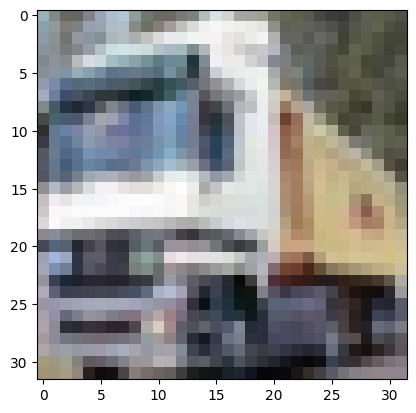

In [9]:
plt.imshow(cifar10_train[1][0].transpose(0, 1).transpose(1, 2))

In [10]:
X_train = torch.stack([cifar10_train[i][0] for i in range(len(cifar10_train))])

print(X_train.dtype, X_train.shape)

mean =  torch.mean(X_train, dim=[0, 2, 3])
std =  torch.std(X_train, dim=[0, 2, 3])
# print(f"mean = {mean:.2f}, std = {std:.2f}")

torch.float32 torch.Size([50000, 3, 32, 32])


In [11]:
from torch.utils.data import DataLoader

Аугментация позаимствована из [ноутбука](https://www.kaggle.com/code/vikasbhadoria/cifar10-high-accuracy-model-build-on-pytorch)

In [25]:
transform_train = T.Compose([
    T.RandomHorizontalFlip(p=0.5), 
    T.RandomRotation(10),
    T.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    T.RandomCrop(32, padding=4),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # T.GaussianBlur(kernel_size=(3, 3), sigma=(0.05, 0.5)),
    # T.RandomEqualize(p=0.2),
    # T.RandomGrayscale(p=0.1),
    T.ToTensor(), 
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_val = T.Compose([
    T.ToTensor(), 
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar10_train = load_cifar10(True, transform = transform_train)
cifar10_val = load_cifar10(False, transform = transform_val)

batch_size_train = 64
batch_size_test = 512

train_cifar10_loader = DataLoader(
    dataset=cifar10_train,
    batch_size=batch_size_train,
    shuffle=True,
    drop_last=True,
    num_workers=9
)

val_cifar10_loader = torch.utils.data.DataLoader(
    dataset=cifar10_val,
    batch_size=batch_size_test,
    shuffle=False,
    drop_last=False,
    num_workers=6
)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
torch.cuda.empty_cache()

In [14]:
model = LogReg(32 * 32 * 3, 10).to(device)

writer = SummaryWriter()

train_val(
    network=model,
    criterion=nn.functional.cross_entropy,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4),
    train_loader=train_cifar10_loader,
    val_loader=val_cifar10_loader,
    n_epochs=20,
    writer=writer,
    logging_interval=5,
    model_name='cifar10_logreg'
)

NameError: name 'LogReg' is not defined

AlexNet

In [16]:
images, labels = next(iter(train_cifar10_loader))

print(images.shape)

torch.Size([64, 3, 32, 32])


In [44]:
model(images).shape

torch.Size([64, 256, 4, 4])

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, channels: int, pairs_cnt: int):
        super().__init__()
        self.conv_pairs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(channels, channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(channels),
                nn.ReLU(),
                nn.Conv2d(channels, channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(channels),
            )
            for _ in range(pairs_cnt)
        ])
        
        self.relu_blocks = nn.ModuleList([nn.ReLU() for _ in range(pairs_cnt)])
        
        self.pairs_cnt = pairs_cnt
    
    def forward(self, x):
        for i in range(self.pairs_cnt):
            x = self.relu_blocks[i](x + self.conv_pairs[i](x))
        
        return x

class ConvDownsample(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * 2, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(in_channels * 2),
            nn.ReLU(),
            nn.Conv2d(in_channels * 2, in_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels * 2),
        )
        
        self.downsample_id = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * 2, kernel_size=1, stride=2),
            nn.BatchNorm2d(in_channels * 2),
        )
        
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.conv_block(x) + self.downsample_id(x)
        x = self.activation(x)
        
        return x

class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.head = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 32 --> 16
        )
        
        self.middle = nn.Sequential(
            ConvBlock(32, 2),
            
            ConvDownsample(32), # 16 --> 8
            ConvBlock(64, 1),
            
            ConvDownsample(64), # 8 --> 4
            ConvBlock(128, 1),
        )
        
        self.tail = nn.Sequential(
            nn.AvgPool2d(kernel_size=2), # 4 --> 2
            nn.Flatten(),
            nn.BatchNorm1d(128 * 4),
            nn.Linear(128 * 4, 10, bias=True),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Linear(128, 10),
        )
    
    def forward(self, x):
        x = self.head(x)
        x = self.middle(x)
        x = self.tail(x)
        
        return x

In [15]:
model = MyResNet()
sum(p.numel() for p in model.parameters() if p.requires_grad)

726250

In [23]:
optimizer.state_dict()['param_groups'][0]['lr']

0.001

In [27]:
model = MyResNet().to(device)

writer = SummaryWriter("MyResNet_mod_learning")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)

train_val(
    network=model,
    criterion=nn.functional.cross_entropy,
    optimizer=optimizer,
    train_loader=train_cifar10_loader,
    val_loader=val_cifar10_loader,
    n_epochs=350,
    writer=writer,
    lr_scheduler=lr_scheduler,
    logging_interval=100,
    # run_name='cifar10_alex_dropout',
    # model_description_dict={
    #     'model_name': 'cifar10_alex_dropout',
    #     'optimizer_initial_lr': 1e-4,
    #     'lr_scheduler_type': 'StepLR',
    #     'lr_scheduler_step_size': 15,
    #     'lr_scheduler_gamma': 0.75,
    # }
)

writer.flush()

Test set: Avg. loss: 2.3040 Accuracy: 1000/10000 (10%)
Test set: Avg. loss: 1.3219 Accuracy: 5296/10000 (53%)
Test set: Avg. loss: 0.9826 Accuracy: 6481/10000 (65%)
Test set: Avg. loss: 0.9005 Accuracy: 6944/10000 (69%)
Test set: Avg. loss: 0.8709 Accuracy: 7014/10000 (70%)
Test set: Avg. loss: 0.7895 Accuracy: 7315/10000 (73%)
Test set: Avg. loss: 0.6704 Accuracy: 7772/10000 (78%)
Test set: Avg. loss: 0.6486 Accuracy: 7777/10000 (78%)
Test set: Avg. loss: 0.6833 Accuracy: 7710/10000 (77%)
Test set: Avg. loss: 0.6233 Accuracy: 7837/10000 (78%)
Test set: Avg. loss: 0.5639 Accuracy: 8080/10000 (81%)
Test set: Avg. loss: 0.5633 Accuracy: 8109/10000 (81%)
Test set: Avg. loss: 0.5500 Accuracy: 8144/10000 (81%)
Test set: Avg. loss: 0.4989 Accuracy: 8262/10000 (83%)
Test set: Avg. loss: 0.5178 Accuracy: 8218/10000 (82%)
Test set: Avg. loss: 0.4843 Accuracy: 8357/10000 (84%)
Test set: Avg. loss: 0.5358 Accuracy: 8189/10000 (82%)
Test set: Avg. loss: 0.4801 Accuracy: 8379/10000 (84%)
Test set: 


KeyboardInterrupt



In [28]:
import pathlib
path = pathlib.Path('./cifar10_own_resnet.bin')

with open(path, "wb") as f:
    torch.save(
        obj=model.state_dict(),
        f=f
    )

In [33]:
model_ld = MyResNet()
model_ld.load_state_dict(torch.load(path))

<All keys matched successfully>

In [38]:
val_epoch(
    model_ld.to(device),
    val_cifar10_loader,
    nn.functional.cross_entropy,
    writer=SummaryWriter("test"),
    epoch_no=0,
)

Test set: Avg. loss: 0.3135 Accuracy: 9032/10000 (90%)


(0.3134802177429199, 0.9032)

DENSE

In [71]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 32 * 32),
    nn.ReLU(),
    nn.BatchNorm1d(32 * 32),
    nn.Linear(32 * 32, 16 * 16),
    nn.ReLU(),
    nn.BatchNorm1d(16 * 16),
    nn.Linear(16*16, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 10),
).to(device)

writer = SummaryWriter()

train_val(
    network=model,
    criterion=nn.functional.cross_entropy,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4),
    train_loader=train_cifar10_loader,
    val_loader=val_cifar10_loader,
    n_epochs=20,
    writer=writer,
    logging_interval=5,
    model_name='cifar10_dense_deep'
)

writer.flush()

Test set: Avg. loss: 2.3053 Accuracy: 1000/10000 (10%)
Test set: Avg. loss: 1.6131 Accuracy: 4338/10000 (43%)
Test set: Avg. loss: 1.4802 Accuracy: 4754/10000 (48%)
Test set: Avg. loss: 1.4342 Accuracy: 4930/10000 (49%)
Test set: Avg. loss: 1.3913 Accuracy: 5102/10000 (51%)
Test set: Avg. loss: 1.3489 Accuracy: 5240/10000 (52%)
Test set: Avg. loss: 1.3470 Accuracy: 5242/10000 (52%)
Test set: Avg. loss: 1.3223 Accuracy: 5276/10000 (53%)
Test set: Avg. loss: 1.3230 Accuracy: 5442/10000 (54%)
Test set: Avg. loss: 1.3163 Accuracy: 5447/10000 (54%)
Test set: Avg. loss: 1.3460 Accuracy: 5389/10000 (54%)
Test set: Avg. loss: 1.3456 Accuracy: 5460/10000 (55%)
Test set: Avg. loss: 1.3573 Accuracy: 5382/10000 (54%)
Test set: Avg. loss: 1.3862 Accuracy: 5435/10000 (54%)
Test set: Avg. loss: 1.3697 Accuracy: 5499/10000 (55%)
Test set: Avg. loss: 1.4276 Accuracy: 5399/10000 (54%)
Test set: Avg. loss: 1.4370 Accuracy: 5405/10000 (54%)
Test set: Avg. loss: 1.4720 Accuracy: 5420/10000 (54%)
Test set: 

In [18]:
transform_train = T.Compose([
    T.ToTensor(), 
    T.Normalize(mean, std),
    T.RandomHorizontalFlip(p=0.2), 
    T.RandomVerticalFlip(p=0.2),
    T.RandomRotation(30),
    T.RandomGrayscale(p=0.1)]
)

transform_val = T.Compose([T.ToTensor(), T.Normalize(mean, std)])

cifar10_train = load_cifar10(True, transform = transform_train)
cifar10_val = load_cifar10(False, transform = transform_val)

batch_size_train = 64
batch_size_test = 1000

train_cifar10_loader = DataLoader(
    dataset=cifar10_train,
    batch_size=batch_size_train,
    shuffle=True,
    drop_last=True,
    num_workers=6
)

val_cifar10_loader = torch.utils.data.DataLoader(
    dataset=cifar10_val,
    batch_size=batch_size_test,
    shuffle=False,
    drop_last=False,
    num_workers=3
)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 32 * 32),
    nn.ReLU(),
    nn.BatchNorm1d(32 * 32),
    nn.Linear(32 * 32, 16 * 16),
    nn.ReLU(),
    nn.BatchNorm1d(16 * 16),
    nn.Linear(16*16, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 10),
).to(device)

writer = SummaryWriter()

train_val(
    network=model,
    criterion=nn.functional.cross_entropy,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4),
    train_loader=train_cifar10_loader,
    val_loader=val_cifar10_loader,
    n_epochs=20,
    writer=writer,
    logging_interval=5,
)

writer.flush()

KeyboardInterrupt: 

In [19]:
print(device)
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 32 * 32),
    nn.ReLU(),
    nn.BatchNorm1d(32 * 32),
    nn.Linear(32 * 32, 16 * 16),
    nn.ReLU(),
    nn.BatchNorm1d(16 * 16),
    nn.Linear(16*16, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 10),
).to(device)

writer = SummaryWriter()

train_val(
    network=model,
    criterion=nn.functional.cross_entropy,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.25 * 1e-4),
    train_loader=train_cifar10_loader,
    val_loader=val_cifar10_loader,
    n_epochs=250,
    writer=writer,
    logging_interval=20,
    model_name='cifar10_dense_deep'
)

writer.flush()

cuda:0
Test set: Avg. loss: 2.3065 Accuracy: 1000/10000 (10%)
Test set: Avg. loss: 2.1761 Accuracy: 2035/10000 (20%)
Test set: Avg. loss: 2.0076 Accuracy: 2804/10000 (28%)
Test set: Avg. loss: 1.8989 Accuracy: 3203/10000 (32%)
Test set: Avg. loss: 1.8230 Accuracy: 3552/10000 (36%)
Test set: Avg. loss: 1.7662 Accuracy: 3739/10000 (37%)
Test set: Avg. loss: 1.7322 Accuracy: 3899/10000 (39%)
Test set: Avg. loss: 1.6866 Accuracy: 4015/10000 (40%)
Test set: Avg. loss: 1.6646 Accuracy: 4141/10000 (41%)
Test set: Avg. loss: 1.6416 Accuracy: 4224/10000 (42%)
Test set: Avg. loss: 1.6187 Accuracy: 4329/10000 (43%)
Test set: Avg. loss: 1.5924 Accuracy: 4399/10000 (44%)
Test set: Avg. loss: 1.5797 Accuracy: 4461/10000 (45%)
Test set: Avg. loss: 1.5501 Accuracy: 4494/10000 (45%)
Test set: Avg. loss: 1.5502 Accuracy: 4555/10000 (46%)
Test set: Avg. loss: 1.5299 Accuracy: 4635/10000 (46%)
Test set: Avg. loss: 1.5179 Accuracy: 4668/10000 (47%)
Test set: Avg. loss: 1.5034 Accuracy: 4721/10000 (47%)
Tes

KeyboardInterrupt: 

In [25]:
batch_size_train = 1024
batch_size_test = 10_000

train_cifar10_loader = DataLoader(
    dataset=cifar10_train,
    batch_size=batch_size_train,
    shuffle=True,
    drop_last=True,
    num_workers=6
)

val_cifar10_loader = torch.utils.data.DataLoader(
    dataset=cifar10_val,
    batch_size=batch_size_test,
    shuffle=False,
    drop_last=False,
    num_workers=3
)

In [26]:
print(device)
deep_dense = nn.Sequential(*([nn.Linear(64, 64), nn.ReLU(), nn.BatchNorm1d(64)] * 10)
)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 32 * 32),
    nn.ReLU(),
    nn.BatchNorm1d(32 * 32),
    nn.Linear(32 * 32, 16 * 16),
    nn.ReLU(),
    nn.BatchNorm1d(16 * 16),
    nn.Linear(16*16, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    deep_dense,
    nn.Linear(64, 10),
).to(device)

writer = SummaryWriter()

train_val(
    network=model,
    criterion=nn.functional.cross_entropy,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.25 * 1e-4),
    train_loader=train_cifar10_loader,
    val_loader=val_cifar10_loader,
    n_epochs=1_000,
    writer=writer,
    logging_interval=20,
    model_name='cifar10_dense_deep'
)

writer.flush()

cuda:0
Test set: Avg. loss: 2.3063 Accuracy: 1000/10000 (10%)
Test set: Avg. loss: 2.3831 Accuracy: 1159/10000 (12%)
Test set: Avg. loss: 2.3601 Accuracy: 1292/10000 (13%)
Test set: Avg. loss: 2.3314 Accuracy: 1320/10000 (13%)
Test set: Avg. loss: 2.3104 Accuracy: 1460/10000 (15%)
Test set: Avg. loss: 2.2940 Accuracy: 1594/10000 (16%)
Test set: Avg. loss: 2.2749 Accuracy: 1633/10000 (16%)
Test set: Avg. loss: 2.2607 Accuracy: 1751/10000 (18%)
Test set: Avg. loss: 2.2372 Accuracy: 1809/10000 (18%)
Test set: Avg. loss: 2.2232 Accuracy: 1948/10000 (19%)
Test set: Avg. loss: 2.2032 Accuracy: 2064/10000 (21%)
Test set: Avg. loss: 2.1863 Accuracy: 2108/10000 (21%)
Test set: Avg. loss: 2.1681 Accuracy: 2218/10000 (22%)
Test set: Avg. loss: 2.1479 Accuracy: 2277/10000 (23%)
Test set: Avg. loss: 2.1293 Accuracy: 2398/10000 (24%)
Test set: Avg. loss: 2.1170 Accuracy: 2438/10000 (24%)
Test set: Avg. loss: 2.0994 Accuracy: 2492/10000 (25%)
Test set: Avg. loss: 2.0822 Accuracy: 2614/10000 (26%)
Tes

## `Бонус. Побейте бейзлайн (3 балла)`

На датасете `CIFAR-10` обучите модель, которая выдает аккураси `>=0.9`.

In [ ]:
# your code is here